## Pre-Trained Model Evaluation

In [2]:
import sys
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import json
from bert_serving.client import BertClient
import tensorflow as tf
import csv
import json
import itertools
import re
import random
import matplotlib.pyplot as plt

W0703 19:48:00.251574 139670899906304 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_hub/native_module.py:54: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0703 19:48:00.254606 139670899906304 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_hub/__init__.py:65: The name tf.VERSION is deprecated. Please use tf.version.VERSION instead.



### Download the bert model
You only need to do this once

In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-24_H-1024_A-16.zip 

### Run the BERT workers

In [ ]:
!bert-serving-start -model_dir uncased_L-24_H-1024_A-16 -num_worker=4

### Read in the baseline queries

In [4]:
qs_file = './sample_questions.csv'
base_qs = pd.read_csv(qs_file)
base_qs.head(n=10)

,Saved Query,New Query
0,I really do not like this product,I really like this product
1,Where can I view my settings,I can't find the settings page
2,How much will this cost?,Is this expensive?
3,How do I change my password,change How I do password my
4,Blah blah blah blah,Can I get some help?
5,"Hello, is there anyone there?",Does this integrate with gmail?
6,Where is your data stored?,How secure is your product
7,What temperature is it today?,What time is the film in the cinema
8,Can I sign up for a free trial,Do I need a credit card to get started?
9,What is the Capital of Ireland?,What time is the game on?


### Download the USE module from TF Hub

In [5]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" 
embed = hub.Module(module_url)

W0703 19:48:11.836884 139670899906304 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_hub/module.py:104: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 19:48:11.854900 139670899906304 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_hub/resolver.py:73: The name tf.logging.log_first_n is deprecated. Please use tf.compat.v1.logging.log_first_n instead.

W0703 19:48:11.855700 139670899906304 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_hub/resolver.py:73: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.

W0703 19:48:11.856588 139670899906304 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_hub/resolver.py:80: The name tf.gfil

### Download the ELMO module

In [6]:
elmo_module_url = "https://tfhub.dev/google/elmo/2"
elmo_embed = hub.Module(elmo_module_url)

### Find the similarity using angular distance
Angular distance is a form of cosine similarity

In [7]:
sts_input1 = tf.placeholder(tf.float64, shape=(None))
sts_input2 = tf.placeholder(tf.float64, shape=(None))

# For evaluation we use exactly normalized rather than
# approximately normalized.
sts_encode1 = tf.nn.l2_normalize((sts_input1), axis=1)
sts_encode2 = tf.nn.l2_normalize((sts_input2), axis=1)

cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
clip_cosine_similarities = tf.clip_by_value(cosine_similarities, 0.0, 1.0)
sim_scores = 1.0 - tf.divide(tf.acos(clip_cosine_similarities), 3.14)

def get_scores(session, text_a, text_b):
    """Returns the similarity scores"""
    emba, embb, scores= session.run(
        [sts_encode1, sts_encode2, sim_scores],
        feed_dict={
            sts_input1: text_a,
            sts_input2: text_b
        })
    return(emba, embb, scores)

### Create an interactive TF session

In [8]:
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
session.run(tf.tables_initializer())

### Find the most similar sentences using BERT embeddings

In [ ]:
results = []
queries = [q for q in base_qs['Saved Query']]
examples = [e for e in base_qs['New Query']]
bc = BertClient(check_length=False)
example_emb = bc.encode(examples)

for i, q in enumerate(queries):
    
    # Get the BERT embeddings score and find the best matching sentences
    new_emb = bc.encode([q])
    emba, embb, sim_score = get_scores(session, new_emb.tolist(), example_emb.tolist())
    base_qs['Score'] = sim_score
    sort_df = base_qs.sort_values('Score', ascending=False)
    best = sort_df.head(n=1)
    ans = (best['New Query']).tolist()[0]
    
    # Get the USE embeddings score for the matching sentences
    use1, useb, use_score = get_scores(session, session.run(embed([q])), session.run(embed([ans])))
    
    # Get the ELMO embeddings score for the matching sentences
    elmo1, elmo2, elmo_score = get_scores(session, session.run(elmo_embed([q])), session.run(elmo_embed([ans])))

    print("Result {}:\nQuestion {}\nBest Match {}".format(i+1, q, ans))  
    results.append([q, ans, np.round((best['Score']).tolist()[0], 3), 
                    np.round(use_score.tolist()[0], 3), 
                    np.round(elmo_score.tolist()[0], 3)])
    df = pd.DataFrame(results, columns=['Saved Query', 'New Query', 'BERT Score', 'USE Score', 'ELMO Score'])

In [8]:
df = df.sort_values('BERT Score', ascending=False)
df.index = np.arange(1,len(df)+1)
df


,Saved Query,New Query,BERT Score,USE Score,ELMO Score
1,How much will this cost?,Is this expensive?,0.892,0.803,0.742
2,Where is your data stored?,How secure is your product,0.890,0.625,0.765
3,What temperature is it today?,What time is the game on?,0.880,0.677,0.746
4,How do I change my password,I can't find the settings page,0.868,0.671,0.717
5,Can I sign up for a free trial,Do I need a credit card to get started?,0.868,0.736,0.753
6,Where can I view my settings,Does this integrate with gmail?,0.866,0.620,0.717
7,I really do not like this product,I really like this product,0.865,0.747,0.864
8,What is the Capital of Ireland?,What time is the film in the cinema,0.865,0.578,0.663
9,"Hello, is there anyone there?",What time is the game on?,0.832,0.594,0.680
10,Blah blah blah blah,Does this integrate with gmail?,0.765,0.519,0.585


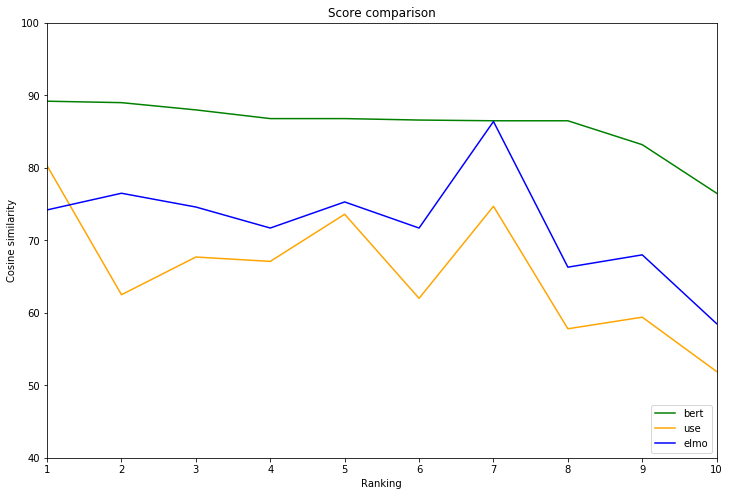

In [10]:
bert = [r*100 for r in df['BERT Score']]
use = [r*100 for r in df['USE Score']]
elmo = [r*100 for r in df['ELMO Score']]

plt.figure(figsize=(12, 8))
rank = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.xlim([1, 10])
plt.ylim([40, 100])
plt.plot(rank, bert, color='green')
plt.plot(rank, use, color='orange')
plt.plot(rank, elmo, color='blue')
plt.xlabel("Ranking")
plt.ylabel('Cosine similarity')
plt.title("Score comparison")
plt.legend(["bert", "use", "elmo"], loc=4)
plt.savefig("BERT model_comparison")
plt.show()

In [9]:
results = []
queries = [q for q in base_qs['Saved Query']]
examples = [e for e in base_qs['New Query']]
bc = BertClient(check_length=False)

for i, q in enumerate(queries):
    
    # Get the USE embeddings score for the matching sentences
    use1, useb, use_score = get_scores(session, session.run(embed([q])), session.run(embed(examples)))
    
    base_qs['Score'] = use_score
    sort_df = base_qs.sort_values('Score', ascending=False)
    best = sort_df.head(n=1)
    ans = (best['New Query']).tolist()[0]
    
    # Get the ELMO embeddings score for the matching sentences
    elmo1, elmo2, elmo_score = get_scores(session, session.run(elmo_embed([q])), session.run(elmo_embed([ans])))
    # Get the BERT embeddings score and find the best matching sentences
    new_emb = bc.encode([q])
    save_emb = bc.encode([ans])
    emba, embb, bert_score = get_scores(session, new_emb.tolist(), save_emb.tolist())
    
    print("{}: {}: {}: {}".format(q, ans, use_score, elmo_score))  
    results.append([q, ans, np.round(elmo_score.tolist()[0], 3), 
                    np.round(use_score.tolist()[0], 3), 
                    np.round((best['Score']).tolist()[0], 3)])
    df = pd.DataFrame(results, columns=['Saved Query', 'New Query', 'USE Score', 'BERT Score','ELMO Score'])

I really do not like this product: I really like this product: [0.74743642 0.56324132 0.61801848 0.54669346 0.59655949 0.5268201
 0.58462825 0.49974639 0.55162396 0.49974639]: [0.86375383]
Where can I view my settings: I can't find the settings page: [0.54152227 0.82407737 0.52529959 0.64732134 0.59830295 0.62034671
 0.54166945 0.60852898 0.56436388 0.62029246]: [0.71781397]
How much will this cost?: Is this expensive?: [0.59793322 0.56694558 0.80324722 0.52709434 0.61297099 0.57004207
 0.60277072 0.61415834 0.64619797 0.59590248]: [0.74247178]
How do I change my password: change How I do password my: [0.53757991 0.67064965 0.52552733 0.88330973 0.62440804 0.6250195
 0.61467375 0.56159662 0.64845157 0.58505201]: [0.81114471]
Blah blah blah blah: Can I get some help?: [0.58631497 0.50521383 0.53215951 0.54350224 0.63920364 0.5191529
 0.49974639 0.49974639 0.51740571 0.52475955]: [0.58128593]
Hello, is there anyone there?: Can I get some help?: [0.55921744 0.54919871 0.56503569 0.5612873

In [10]:
df = df.sort_values('USE Score', ascending=False)
df.index = np.arange(1,len(df)+1)
df

,Saved Query,New Query,USE Score,BERT Score,ELMO Score
1,I really do not like this product,I really like this product,0.864,0.747,0.747
2,How do I change my password,change How I do password my,0.811,0.538,0.883
3,Can I sign up for a free trial,Do I need a credit card to get started?,0.753,0.585,0.736
4,What temperature is it today?,What time is the game on?,0.746,0.547,0.677
5,How much will this cost?,Is this expensive?,0.742,0.598,0.803
6,Where can I view my settings,I can't find the settings page,0.718,0.542,0.824
7,"Hello, is there anyone there?",Can I get some help?,0.693,0.559,0.685
8,What is the Capital of Ireland?,What time is the game on?,0.679,0.500,0.591
9,Where is your data stored?,I can't find the settings page,0.675,0.517,0.649
10,Blah blah blah blah,Can I get some help?,0.581,0.586,0.639


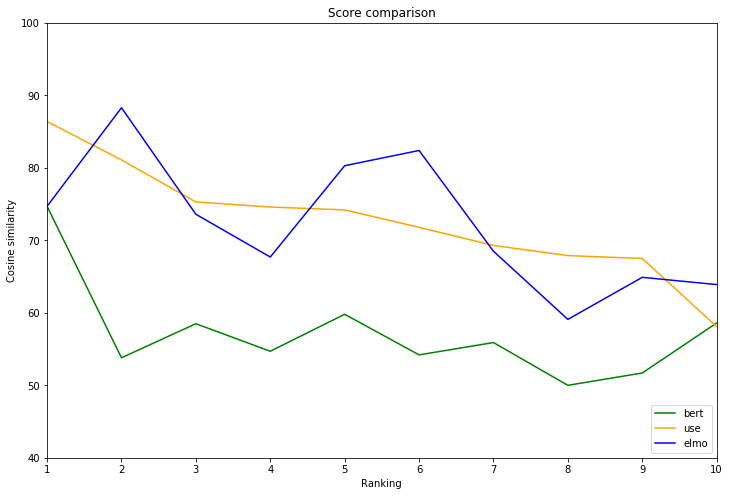

In [11]:
bert = [r*100 for r in df['BERT Score']]
use = [r*100 for r in df['USE Score']]
elmo = [r*100 for r in df['ELMO Score']]

plt.figure(figsize=(12, 8))
rank = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.xlim([1, 10])
plt.ylim([40, 100])
plt.plot(rank, bert, color='green')
plt.plot(rank, use, color='orange')
plt.plot(rank, elmo, color='blue')
plt.xlabel("Ranking")
plt.ylabel('Cosine similarity')
plt.title("Score comparison")
plt.legend(["bert", "use", "elmo"], loc=4)
plt.savefig("USE model_comparison")
plt.show()